In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [1]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 34.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/XL2248/MSCTD

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 13.18 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.


In [ ]:
#!gdown --id 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
!cp /content/drive/MyDrive/deep_learning_project/train_ende.zip /content/

In [ ]:
#!gdown --id 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
!cp /content/drive/MyDrive/deep_learning_project/test.zip /content/

In [ ]:
#!gdown --id 12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA
!cp /content/drive/MyDrive/deep_learning_project/dev.zip /content/

In [ ]:
!mkdir /content/dataset

In [ ]:
!mkdir /content/dataset/base

In [ ]:
!unzip /content/train_ende.zip -d /content/dataset/base
!unzip /content/test.zip -d /content/dataset/base
!unzip /content/dev.zip -d /content/dataset/base

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/base/dev/1054.jpg  
  inflating: /content/dataset/base/dev/1055.jpg  
  inflating: /content/dataset/base/dev/1056.jpg  
  inflating: /content/dataset/base/dev/1057.jpg  
  inflating: /content/dataset/base/dev/1058.jpg  
  inflating: /content/dataset/base/dev/1059.jpg  
  inflating: /content/dataset/base/dev/106.jpg  
  inflating: /content/dataset/base/dev/1060.jpg  
  inflating: /content/dataset/base/dev/1061.jpg  
  inflating: /content/dataset/base/dev/1062.jpg  
  inflating: /content/dataset/base/dev/1063.jpg  
  inflating: /content/dataset/base/dev/1064.jpg  
  inflating: /content/dataset/base/dev/1065.jpg  
  inflating: /content/dataset/base/dev/1066.jpg  
  inflating: /content/dataset/base/dev/1067.jpg  
  inflating: /content/dataset/base/dev/1068.jpg  
  inflating: /content/dataset/base/dev/1069.jpg  
  inflating: /content/dataset/base/dev/107.jpg  
  inflating: /content/dataset/base/dev/1070.jpg  
 

In [2]:
import os
import glob
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import cv2
import ast
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import transforms
from torch.distributions import Dirichlet, Beta
from opt_einsum import contract
from facenet_pytorch import MTCNN,extract_face
import torchvision.transforms as T
from PIL import Image, ImageDraw
import collections
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay, accuracy_score
import shutil
import random
from collections import Counter
import matplotlib
from itertools import groupby
from scipy import stats

In [ ]:
class MSCTDDataset(Dataset):
    def __init__(self,type_dataset, ende_dir, dataset_path, transform=T.ToTensor(), target_transform=None):

        self.type_dataset = type_dataset
        self.english_file = open(ende_dir + '/english_' + self.type_dataset + '.txt', 'r')
        self.english_Lines = [line.strip() for line in self.english_file]
        

        self.image_index_file = open(ende_dir + '/image_index_' + self.type_dataset + '.txt', 'r')
        self.image_index_Lines = [ast.literal_eval(line.strip()) for line in self.image_index_file]

        self.sentiment_file = open(ende_dir + '/sentiment_' + self.type_dataset + '.txt', 'r')
        self.sentiment_Lines = [int(line.strip()) for line in self.sentiment_file]

        self.id = [i for i in range(len(self.english_Lines))]

        self.dataset_path = dataset_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.english_Lines)

    def __getitem__(self, idx):

        id = self.id[idx]
        text = self.english_Lines[idx]
        
        if self.type_dataset == 'train':
          img_path = os.path.join(self.dataset_path, 'train_ende/' + str(idx) + '.jpg')
        else:
          img_path = os.path.join(self.dataset_path, self.type_dataset + '/' + str(idx) + '.jpg')

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = cv2.resize(img, (720,338), interpolation = cv2.INTER_AREA)


        sentiment = self.sentiment_Lines[idx]
        one_hot_sentiment = np.zeros(3)
        one_hot_sentiment[sentiment] = 1
        

        value_in_sublist = map(lambda x: id in x, self.image_index_Lines)
        my_idx = list(value_in_sublist).index(True) 
        conversation_id = str(self.image_index_Lines[my_idx])


        if self.transform:
            img_array = self.transform(img_array)
        if self.target_transform:
            label = self.target_transform(label)
        
        sample_dict = {'id':id, 'text': text , 'image':img_array ,'sentiment':sentiment,'sentiment_1':one_hot_sentiment, 'conversation_id':conversation_id}

        return sample_dict

In [ ]:
train_data = MSCTDDataset('train', '/content/MSCTD/MSCTD_data/ende', '/content/dataset/base')
dev_data = MSCTDDataset('dev', '/content/MSCTD/MSCTD_data/ende', '/content/dataset/base')
test_data = MSCTDDataset('test', '/content/MSCTD/MSCTD_data/ende', '/content/dataset/base')

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=False)
dev_dataloader = DataLoader(dev_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
help(MTCNN)

Help on class MTCNN in module facenet_pytorch.models.mtcnn:

class MTCNN(torch.nn.modules.module.Module)
 |  MTCNN(image_size=160, margin=0, min_face_size=20, thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True, select_largest=True, selection_method=None, keep_all=False, device=None)
 |  
 |  MTCNN face detection module.
 |  
 |  This class loads pretrained P-, R-, and O-nets and returns images cropped to include the face
 |  only, given raw input images of one of the following types:
 |      - PIL image or list of PIL images
 |      - numpy.ndarray (uint8) representing either a single image (3D) or a batch of images (4D).
 |  Cropped faces can optionally be saved to file
 |  also.
 |  
 |  Keyword Arguments:
 |      image_size {int} -- Output image size in pixels. The image will be square. (default: {160})
 |      margin {int} -- Margin to add to bounding box, in terms of pixels in the final image. 
 |          Note that the application of the margin differs slightly from the 

# بخش اول

## گام اول

## example for 1 batch:

In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)

In [ ]:
first_batch = next(iter(train_loader))

In [ ]:
!mkdir /content/batch_test

In [ ]:
#using detect from mtcnn
transform = T.ToPILImage()
img = transform(first_batch['image'][15])
mtcnn = MTCNN(image_size =96,keep_all=True,select_largest=False,post_process=False)
boxes, probs = mtcnn.detect(img, landmarks=False)
# Draw boxes and save faces
img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)
for i, (box, p) in enumerate(zip(boxes, probs)):
  print(i)
  print(p)
  print(box.tolist())
  draw.rectangle(box.tolist(), width=5)
  extract_face(img, box, save_path='detected_face_{}.png'.format(i))

0
0.9999479
[437.17974853515625, 52.269752502441406, 493.8608093261719, 124.80455780029297]
1
0.7978335
[89.48487854003906, 12.622248649597168, 126.7740707397461, 68.89573669433594]


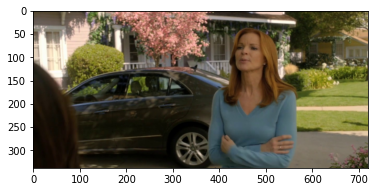

In [ ]:
plt.imshow(first_batch['image'][15].permute(1, 2, 0))
plt.show()

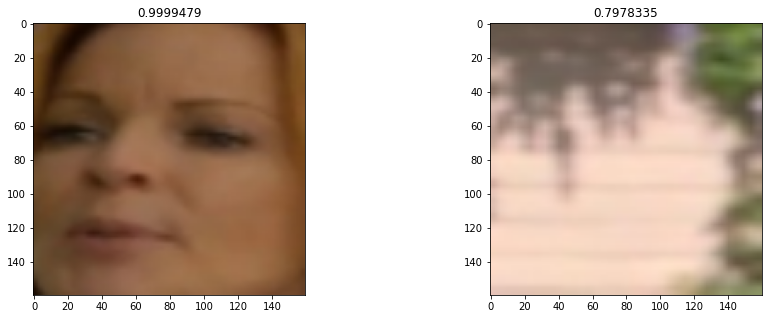

In [ ]:
faces = [cv2.cvtColor(cv2.imread('detected_face_'+str(i)+'.png'),cv2.COLOR_BGR2RGB) for i in range(2) ]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for face, ax, p in zip(faces, axes, probs):
    ax.imshow(face) #this works with .extend(faces[i]) not .extend(faces[i].tolist())
    ax.set_title(str(p))
fig.show()

I wanted to try filtering faces by size or probability but prob of the wrong detection is 0.8 and its box size is large enough.
So I couldn't filter faces

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, select_largest=False,post_process=False, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces

sentiment_batch = []
face_batch = []
imgs_PIL = []
j = int(0)
for i in range(len(first_batch['image'])):
  imgs_PIL.append(transform(first_batch['image'][i])) #mtcnn only accepts batches of PIL image

faces = mtcnn(imgs_PIL) #returns cropped faces resized to 96
for i in range(len(faces)) :
  if faces[i] is not None : # face detected
    face_batch.extend(faces[i])
    for k in range(len(faces[i])):
      cv2.imwrite( f'/content/batch_test/{j+k}.jpg',
                  cv2.cvtColor(faces[i][k].type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))

    sentiment_batch.extend([first_batch['sentiment'][i].item() for j in range(len(faces[i])) ])
    j +=len(faces[i])



/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

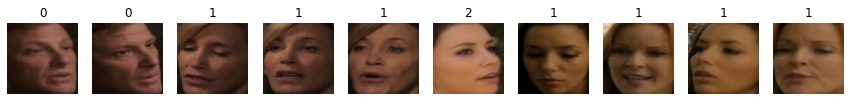

In [ ]:
# Visualize
fig, axes = plt.subplots(1, len(face_batch), figsize=(15, 5))
for face, ax, sent in zip(face_batch, axes, sentiment_batch):
    ax.imshow(face.permute(1, 2, 0).int().numpy()) #this works with .extend(faces[i]) not .extend(faces[i].tolist())
    ax.set_title(str(sent))
    ax.axis('off')
fig.show()

In [ ]:
sentiment_batch

tensor([0, 0, 1, 1, 1, 2, 1, 1, 1, 1])

In [ ]:
face_batch[0]

tensor([[[24., 24., 24.,  ..., 25., 25., 24.],
         [23., 24., 24.,  ..., 25., 25., 25.],
         [23., 24., 24.,  ..., 26., 26., 26.],
         ...,
         [39., 37., 35.,  ..., 34., 29., 26.],
         [37., 36., 36.,  ..., 31., 27., 24.],
         [37., 36., 36.,  ..., 29., 28., 25.]],

        [[15., 16., 16.,  ..., 21., 21., 20.],
         [16., 17., 17.,  ..., 21., 21., 21.],
         [16., 17., 17.,  ..., 22., 22., 22.],
         ...,
         [19., 18., 18.,  ..., 19., 18., 18.],
         [18., 18., 18.,  ..., 20., 19., 17.],
         [17., 17., 17.,  ..., 21., 20., 19.]],

        [[ 8.,  9.,  9.,  ..., 12., 12., 11.],
         [ 8.,  9.,  9.,  ..., 12., 12., 12.],
         [ 8.,  9.,  9.,  ..., 13., 13., 13.],
         ...,
         [10.,  9.,  9.,  ..., 13., 12., 12.],
         [ 8.,  9., 10.,  ..., 15., 15., 14.],
         [10., 10., 10.,  ..., 18., 17., 15.]]])

## train/dev/test

I tried to make two datasets. one with all faces and one with at most 10 faces for each picture to check if reducing data(probably unrelated faces with less probability) could help training

In [ ]:
!mkdir /content/dataset/face
!mkdir /content/dataset/face/train
!mkdir /content/dataset/face/dev
!mkdir /content/dataset/face/test

In [ ]:
!mkdir /content/dataset/face2
!mkdir /content/dataset/face2/train
!mkdir /content/dataset/face2/dev
!mkdir /content/dataset/face2/test

### train

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=False, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces


sentiment_train = []
j = int(0)

for batch, sample in enumerate(tqdm(train_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns positions of bbox, eyes, lips ,...
  for i in range(len(faces)) :
    if faces[i] is not None : # face detected
      for k in range(len(faces[i])):
        cv2.imwrite( f'/content/dataset/face/train/{j+k}.jpg',cv2.cvtColor(faces[i][k].type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))

      j +=len(faces[i])
      sentiment_train.extend([sample['sentiment'][i].item() for j in range(len(faces[i])) ])



  0%|          | 0/317 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a

In [ ]:
#delete a folder
#! rm -rf /content/dataset/face/train

In [ ]:
type(sentiment_train[0]) , len(sentiment_train)

(int, 28540)

In [ ]:
pd.DataFrame(sentiment_train, columns=["label"]).to_csv('/content/dataset/face/train.csv')

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=False,select_largest=False, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces


sentiment_train = []
j = int(0)

for batch, sample in enumerate(tqdm(train_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns positions of bbox, eyes, lips ,...
  for i in range(len(faces)) :
    if faces[i] is not None : # face detected
      for k in range(len(faces[i])):
        if k < 10:
          cv2.imwrite( f'/content/dataset/face2/train/{j+k}.jpg',
                      cv2.cvtColor(faces[i][k].type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))
        else:
          break

      #j +=len(faces[i])
      j += k
      #sentiment_train.extend([sample['sentiment'][i].item() for j in range(len(faces[i])) ])
      sentiment_train.extend([sample['sentiment'][i].item() for j in range(k) ])



  0%|          | 0/317 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a

In [ ]:
type(sentiment_train[0]) , len(sentiment_train)

(int, 11030)

In [ ]:
pd.DataFrame(sentiment_train, columns=["label"]).to_csv('/content/dataset/face2/train.csv')

### dev

In [ ]:
sentiment_dev = []
j = int(0)

for batch, sample in enumerate(tqdm(dev_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) 
  for i in range(len(faces)) :
    if faces[i] is not None : # face detected
      for k in range(len(faces[i])):
        cv2.imwrite( f'/content/dataset/face/dev/{j+k}.jpg',cv2.cvtColor(faces[i][k].type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))

      j +=len(faces[i])
      sentiment_dev.extend([sample['sentiment'][i].item() for j in range(len(faces[i])) ])


  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

In [ ]:
type(sentiment_dev[0]) , len(sentiment_dev)

(int, 6638)

In [ ]:
pd.DataFrame(sentiment_dev, columns=["label"]).to_csv('/content/dataset/face/dev.csv')

In [ ]:
sentiment_dev = []
j = int(0)

for batch, sample in enumerate(tqdm(dev_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL)
  for i in range(len(faces)) :
    if faces[i] is not None : # face detected
      for k in range(len(faces[i])):
        if k<10:
          cv2.imwrite( f'/content/dataset/face2/dev/{j+k}.jpg',
                      cv2.cvtColor(faces[i][k].type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))
        else:
          break

      j += k
      sentiment_dev.extend([sample['sentiment'][i].item() for j in range(k) ])

  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

In [ ]:
type(sentiment_dev[0]) , len(sentiment_dev)

(int, 2165)

In [ ]:
pd.DataFrame(sentiment_dev, columns=["label"]).to_csv('/content/dataset/face2/dev.csv')

### test

In [ ]:
sentiment_test = []
j = int(0)

for batch, sample in enumerate(tqdm(test_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns positions of bbox, eyes, lips ,...
  for i in range(len(faces)) :
    if faces[i] is not None : # face detected
      for k in range(len(faces[i])):
        cv2.imwrite( f'/content/dataset/face/test/{j+k}.jpg',cv2.cvtColor(faces[i][k].type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))

      j +=len(faces[i])
      sentiment_test.extend([sample['sentiment'][i].item() for j in range(len(faces[i])) ])


  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

In [ ]:
type(sentiment_test[0]) , len(sentiment_test)

(int, 7169)

In [ ]:
pd.DataFrame(sentiment_test, columns=["label"]).to_csv('/content/dataset/face/test.csv')

In [ ]:
sentiment_test = []
j = int(0)

for batch, sample in enumerate(tqdm(test_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns positions of bbox, eyes, lips ,...
  for i in range(len(faces)) :
    if faces[i] is not None : # face detected
      for k in range(len(faces[i])):
        if k<10:
          cv2.imwrite( f'/content/dataset/face2/test/{j+k}.jpg',
                      cv2.cvtColor(faces[i][k].type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))
        else:
          break

      j +=k
      sentiment_test.extend([sample['sentiment'][i].item() for j in range(k) ])

100%|██████████| 80/80 [04:21<00:00,  3.27s/it]


In [ ]:
type(sentiment_test[0]) , len(sentiment_test)

(int, 2740)

In [ ]:
pd.DataFrame(sentiment_test, columns=["label"]).to_csv('/content/dataset/face2/test.csv')

In [ ]:
!zip -r /content/face.zip /content/dataset/face/*

Streaming output truncated to the last 5000 lines.
  adding: content/dataset/face/train/9412.jpg (deflated 5%)
  adding: content/dataset/face/train/21941.jpg (deflated 4%)
  adding: content/dataset/face/train/12453.jpg (deflated 7%)
  adding: content/dataset/face/train/19348.jpg (deflated 4%)
  adding: content/dataset/face/train/23653.jpg (deflated 6%)
  adding: content/dataset/face/train/26762.jpg (deflated 6%)
  adding: content/dataset/face/train/2822.jpg (deflated 5%)
  adding: content/dataset/face/train/7394.jpg (deflated 4%)
  adding: content/dataset/face/train/6223.jpg (deflated 6%)
  adding: content/dataset/face/train/25454.jpg (deflated 5%)
  adding: content/dataset/face/train/18178.jpg (deflated 5%)
  adding: content/dataset/face/train/872.jpg (deflated 5%)
  adding: content/dataset/face/train/17028.jpg (deflated 6%)
  adding: content/dataset/face/train/9479.jpg (deflated 6%)
  adding: content/dataset/face/train/24990.jpg (deflated 4%)
  adding: content/dataset/face/train/9705

In [ ]:
!zip -r /content/face2.zip /content/dataset/face2/*

Streaming output truncated to the last 5000 lines.
  adding: content/dataset/face2/train/5442.jpg (deflated 5%)
  adding: content/dataset/face2/train/5362.jpg (deflated 5%)
  adding: content/dataset/face2/train/3950.jpg (deflated 6%)
  adding: content/dataset/face2/train/6738.jpg (deflated 5%)
  adding: content/dataset/face2/train/1709.jpg (deflated 5%)
  adding: content/dataset/face2/train/5796.jpg (deflated 6%)
  adding: content/dataset/face2/train/9979.jpg (deflated 6%)
  adding: content/dataset/face2/train/6257.jpg (deflated 7%)
  adding: content/dataset/face2/train/2605.jpg (deflated 6%)
  adding: content/dataset/face2/train/399.jpg (deflated 6%)
  adding: content/dataset/face2/train/6830.jpg (deflated 5%)
  adding: content/dataset/face2/train/6801.jpg (deflated 4%)
  adding: content/dataset/face2/train/5647.jpg (deflated 5%)
  adding: content/dataset/face2/train/5044.jpg (deflated 4%)
  adding: content/dataset/face2/train/5975.jpg (deflated 5%)
  adding: content/dataset/face2/tra

In [ ]:
!cp -r /content/face.zip /content/drive/MyDrive/face_dataset/

In [ ]:
!cp -r /content/face2.zip /content/drive/MyDrive/deep_learning_project/face_dataset/

## use of data for further steps:

In [ ]:
#delete a folder
!rm -rf /content/dataset/face

In [ ]:
!rm -rf /content/dataset/face2

In [ ]:
!gdown --id 1cfeMAEv7G7tH22Rf3Win-ovPdHM-lYyu
#!cp /content/drive/MyDrive/deep_learning_project/face_dataset/face.zip  /content/

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cfeMAEv7G7tH22Rf3Win-ovPdHM-lYyu
To: /content/face.zip
100% 124M/124M [00:01<00:00, 66.7MB/s]


In [ ]:
!gdown --id 19Pw4qzd7lk0k0fKVlMGniY-9b3xuqYRm
#!cp /content/drive/MyDrive/deep_learning_project/face_dataset/face2.zip  /content/

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19Pw4qzd7lk0k0fKVlMGniY-9b3xuqYRm
To: /content/face2.zip
100% 44.9M/44.9M [00:00<00:00, 128MB/s] 


In [ ]:
!unzip /content/face.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/dataset/face/train/9412.jpg  
  inflating: content/dataset/face/train/21941.jpg  
  inflating: content/dataset/face/train/12453.jpg  
  inflating: content/dataset/face/train/19348.jpg  
  inflating: content/dataset/face/train/23653.jpg  
  inflating: content/dataset/face/train/26762.jpg  
  inflating: content/dataset/face/train/2822.jpg  
  inflating: content/dataset/face/train/7394.jpg  
  inflating: content/dataset/face/train/6223.jpg  
  inflating: content/dataset/face/train/25454.jpg  
  inflating: content/dataset/face/train/18178.jpg  
  inflating: content/dataset/face/train/872.jpg  
  inflating: content/dataset/face/train/17028.jpg  
  inflating: content/dataset/face/train/9479.jpg  
  inflating: content/dataset/face/train/24990.jpg  
  inflating: content/dataset/face/train/9705.jpg  
  inflating: content/dataset/face/train/27683.jpg  
  inflating: content/dataset/face/train/1099.jpg  
  inflating: content/d

In [ ]:
!unzip /content/face2.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/dataset/face2/train/5442.jpg  
  inflating: content/dataset/face2/train/5362.jpg  
  inflating: content/dataset/face2/train/3950.jpg  
  inflating: content/dataset/face2/train/6738.jpg  
  inflating: content/dataset/face2/train/1709.jpg  
  inflating: content/dataset/face2/train/5796.jpg  
  inflating: content/dataset/face2/train/9979.jpg  
  inflating: content/dataset/face2/train/6257.jpg  
  inflating: content/dataset/face2/train/2605.jpg  
  inflating: content/dataset/face2/train/399.jpg  
  inflating: content/dataset/face2/train/6830.jpg  
  inflating: content/dataset/face2/train/6801.jpg  
  inflating: content/dataset/face2/train/5647.jpg  
  inflating: content/dataset/face2/train/5044.jpg  
  inflating: content/dataset/face2/train/5975.jpg  
  inflating: content/dataset/face2/train/2687.jpg  
  inflating: content/dataset/face2/train/7139.jpg  
  inflating: content/dataset/face2/train/8842.jpg  
  inflating: c

In [ ]:
!mv /content/content/dataset/face /content/dataset

In [ ]:
!mv /content/content/dataset/face2 /content/dataset

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, data_type, data_dir, transform=T.ToTensor(), target_transform=None):
        self.img_labels = pd.read_csv(os.path.join(data_dir, data_type + '.csv'))
        self.data_dir = data_dir
        self.data_type = data_type
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.data_type, str(self.img_labels.iloc[idx, 0])+'.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return {'img':img, 'label':torch.tensor(label)}

## final dataloader:

In [ ]:
train_set = FaceDataset('train','/content/dataset/face')
train_face_loader = DataLoader(train_set, batch_size=64, shuffle=False)

In [ ]:
dev_set = FaceDataset('dev','/content/dataset/face')
dev_face_loader = DataLoader(dev_set, batch_size=64, shuffle=False)

In [ ]:
test_set = FaceDataset('test','/content/dataset/face')
test_face_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
train_set2 = FaceDataset('train','/content/dataset/face2')
train_face_loader2 = DataLoader(train_set2, batch_size=32, shuffle=False)
dev_set2 = FaceDataset('dev','/content/dataset/face2')
dev_face_loader2 = DataLoader(dev_set2, batch_size=32, shuffle=False)
test_set2 = FaceDataset('test','/content/dataset/face2')
test_face_loader2 = DataLoader(test_set2, batch_size=32, shuffle=False)

In [ ]:
first_batch = next(iter(train_face_loader))

In [ ]:
first_batch['img'][0].dtype

torch.float32

## گام ۲

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5) 
        self.conv2 = nn.Conv2d(16, 32, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.25)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.conv6 = nn.Conv2d(64, 64, 3)
        self.drop2 = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x)) #out= 16*92*92
        x = self.pool(F.relu(self.conv2(x))) #out=32*44*44
        x = self.drop1(x)
        x = F.relu(self.conv3(x))#out= 64*42*42
        x = self.pool(F.relu(self.conv4(x))) #out=64*20*20
        x = self.drop1(x)
        x = F.relu(self.conv5(x)) #out= 64*18*18
        x = self.pool(F.relu(self.conv6(x))) #out=64*8*8
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.fc2(x)
        return x


model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  model.train()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss, correct = 0, 0
  for batch, sample_dict in enumerate(dataloader):
    input = sample_dict['img']
    input = input.to('cuda')
    y = sample_dict['label'].to('cuda')
    # Compute prediction and loss
    pred = model(input)
    loss = loss_fn(pred, y)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 100 == 0:
      loss100, current = loss.item(), batch * len(input)
      print(f"loss: {loss100:>7f}  [{current:>5d}/{size:>5d}]")

    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss += loss.item()

  train_loss /= num_batches
  correct /= size
  return train_loss , correct

def validation_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for sample_dict in dataloader:
            input = sample_dict['img']
            input = input.to(device)  # move input tensor to GPU
            y = sample_dict['label'].to('cuda')
            pred = model(input)
            loss = loss_fn(pred, sample_dict['label'].to('cuda'))
          
            val_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()


    val_loss /= num_batches
    correct /= size
    print()
    print(f"val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return val_loss, correct



def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample_dict in dataloader:
            input = sample_dict['img']
            input = input.to(device)  # move input tensor to GPU
            y = sample_dict['label'].to('cuda')
            pred = model(input)
            loss = loss_fn(pred, sample_dict['label'].to('cuda'))
          
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()


    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

In [ ]:
epochs = 5
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    loss, acc = train_loop(train_face_loader, model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)
    loss_v, acc_v = validation_loop(dev_face_loader, model, loss_fn)
    val_loss.append(loss_v)
    val_acc.append(acc_v)
    torch.cuda.empty_cache()
print("Done!")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 1.106821  [    0/28540]
loss: 1.075391  [ 6400/28540]
loss: 1.115429  [12800/28540]
loss: 1.130340  [19200/28540]
loss: 1.053387  [25600/28540]


 20%|██        | 1/5 [00:46<03:07, 46.98s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.109339 

Epoch 2
-------------------------------
loss: 1.050065  [    0/28540]
loss: 1.090292  [ 6400/28540]
loss: 1.129801  [12800/28540]
loss: 1.126909  [19200/28540]
loss: 1.051827  [25600/28540]


 40%|████      | 2/5 [01:24<02:04, 41.44s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.103874 

Epoch 3
-------------------------------
loss: 1.061167  [    0/28540]
loss: 1.096009  [ 6400/28540]
loss: 1.136944  [12800/28540]
loss: 1.125749  [19200/28540]
loss: 1.061893  [25600/28540]


 60%|██████    | 3/5 [02:01<01:18, 39.46s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.100849 

Epoch 4
-------------------------------
loss: 1.057508  [    0/28540]
loss: 1.101892  [ 6400/28540]
loss: 1.143509  [12800/28540]
loss: 1.125354  [19200/28540]
loss: 1.066052  [25600/28540]


 80%|████████  | 4/5 [02:39<00:38, 38.94s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.098642 

Epoch 5
-------------------------------
loss: 1.058651  [    0/28540]
loss: 1.105092  [ 6400/28540]
loss: 1.149256  [12800/28540]
loss: 1.123698  [19200/28540]
loss: 1.064744  [25600/28540]


100%|██████████| 5/5 [03:16<00:00, 39.31s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.098349 

Done!


In [ ]:
test_loop(test_face_loader, model, loss_fn)

Test Error: 
 Accuracy: 41.5%, Avg loss: 1.091825 



In [ ]:
def visualize_loss_and_acc(loss_values, val_loss_values, acc, val_acc):

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

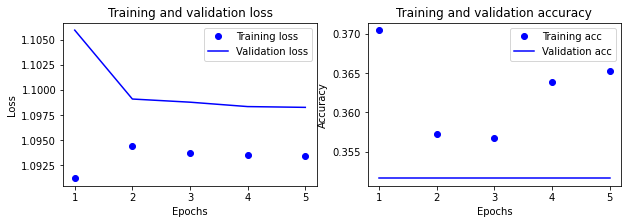

In [ ]:
visualize_loss_and_acc(train_loss, val_loss, train_acc, val_acc)

In [ ]:
# saving
torch.save(model, 'model1.pth')
!cp -r /content/model1.pth /content/drive/MyDrive/deep_learning_project/phase1/

# loading
# model = torch.load('model.pth')
# model.eval()

In [ ]:
!gdown --id 1--bUNhHUnt2f-msOFrmejistLO6E1E18
model1 = Net()
model1 = torch.load('model1.pth', map_location=torch.device(device))
model1.eval()

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1--bUNhHUnt2f-msOFrmejistLO6E1E18
To: /content/model1.pth
100% 4.78M/4.78M [00:00<00:00, 135MB/s]


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
test_pred = []
y_test = []

for batch, sample in enumerate(tqdm(test_face_loader)):
  y_test.extend(sample['label'].numpy().tolist())
  pred = model1(sample['img'].to(device))
  test_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

100%|██████████| 113/113 [00:10<00:00, 11.28it/s]


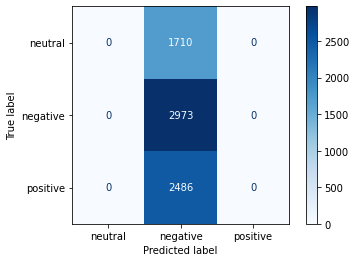

In [ ]:
cm = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)

plt.show()

The model is not learning classes 0 and 2  at all! Maybe features in negative faces were easier to learn or had a better focused distribution

In [ ]:
model2 = Net().to(device)
print(model2)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [ ]:
epochs = 5
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    loss, acc = train_loop(train_face_loader2, model2, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)
    loss_v, acc_v = validation_loop(dev_face_loader2, model2, loss_fn)
    val_loss.append(loss_v)
    val_acc.append(acc_v)
    torch.cuda.empty_cache()
print()
test_loop(test_face_loader2, model2, loss_fn)
print("Done!")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 1.085441  [    0/11030]
loss: 1.092226  [ 3200/11030]
loss: 1.103222  [ 6400/11030]
loss: 1.119056  [ 9600/11030]


 20%|██        | 1/5 [00:14<00:58, 14.62s/it]


val Error: 
 Accuracy: 34.0%, Avg loss: 1.098586 

Epoch 2
-------------------------------
loss: 1.084332  [    0/11030]
loss: 1.097498  [ 3200/11030]
loss: 1.105301  [ 6400/11030]
loss: 1.128790  [ 9600/11030]


 40%|████      | 2/5 [00:29<00:43, 14.54s/it]


val Error: 
 Accuracy: 34.0%, Avg loss: 1.096563 

Epoch 3
-------------------------------
loss: 1.072971  [    0/11030]
loss: 1.096747  [ 3200/11030]
loss: 1.107005  [ 6400/11030]
loss: 1.131672  [ 9600/11030]


 60%|██████    | 3/5 [00:43<00:29, 14.54s/it]


val Error: 
 Accuracy: 34.0%, Avg loss: 1.095729 

Epoch 4
-------------------------------
loss: 1.069023  [    0/11030]
loss: 1.097317  [ 3200/11030]
loss: 1.105503  [ 6400/11030]
loss: 1.132011  [ 9600/11030]


 80%|████████  | 4/5 [00:58<00:14, 14.85s/it]


val Error: 
 Accuracy: 34.0%, Avg loss: 1.095415 

Epoch 5
-------------------------------
loss: 1.067109  [    0/11030]
loss: 1.096049  [ 3200/11030]
loss: 1.105490  [ 6400/11030]
loss: 1.133407  [ 9600/11030]


100%|██████████| 5/5 [01:13<00:00, 14.77s/it]


val Error: 
 Accuracy: 34.0%, Avg loss: 1.095146 




Test Error: 
 Accuracy: 39.0%, Avg loss: 1.107949 

Done!


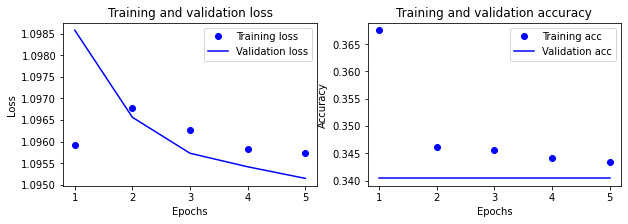

In [ ]:
visualize_loss_and_acc(train_loss, val_loss, train_acc, val_acc)

I thought that maybe by reducing uncessary data - more than 10 faces in 1 picture - we may get better results but so far loss is the same and accuracy decreased.

In [ ]:
torch.save(model, 'model2.pth')
!cp -r /content/model2.pth /content/drive/MyDrive/deep_learning_project/phase1/

## گام ۳

In [ ]:
train_prob = np.zeros(3)
for batch, sample in enumerate(tqdm(train_dataloader)):
  unique, counts = np.unique(sample['sentiment'].numpy(), return_counts=True)
  for i,c in zip(unique, counts):
    train_prob[i] += c
train_prob /= len(train_dataloader.dataset)
print()
print('probabilities of train dataset:')
print(train_prob)




100%|██████████| 317/317 [08:28<00:00,  1.60s/it]


probabilities of train dataset:
[0.34199605 0.38710474 0.27089921]


In [ ]:
val_prob = np.zeros(3)
for batch, sample in enumerate(tqdm(dev_dataloader)):
  unique, counts = np.unique(sample['sentiment'].numpy(), return_counts=True)
  for i,c in zip(unique, counts):
    val_prob[i] += c
val_prob /= len(dev_dataloader.dataset)
print()
print('probabilities of validation dataset:')
print(val_prob)

100%|██████████| 80/80 [02:04<00:00,  1.56s/it]


probabilities of validation dataset:
[0.35097768 0.36302587 0.28599644]


In [ ]:
test_prob = np.zeros(3)
for batch, sample in enumerate(tqdm(test_dataloader)):
  unique, counts = np.unique(sample['sentiment'].numpy(), return_counts=True)
  for i,c in zip(unique, counts):
    test_prob[i] += c
test_prob /= len(test_dataloader.dataset)
print()
print('probabilities of validation dataset:')
print(test_prob)

100%|██████████| 80/80 [01:55<00:00,  1.44s/it]


probabilities of validation dataset:
[0.25616736 0.42687981 0.31695283]


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
#!cp /content/drive/MyDrive/deep_learning_project/phase1/model1.pth  /content/
!gdown --id 1--bUNhHUnt2f-msOFrmejistLO6E1E18
model1 = Net()
model1 = torch.load('model1.pth', map_location=torch.device(device))
model1.eval()

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1--bUNhHUnt2f-msOFrmejistLO6E1E18
To: /content/model1.pth
100% 4.78M/4.78M [00:00<00:00, 182MB/s]


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
train_prob = [0.342,0.387,0.271]

using mean of all faces' prediction probabilities in an image to predict image's label:

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces


train_pred = []


for batch, sample in enumerate(tqdm(train_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) 
  for i in range(len(faces)) :
    if faces[i] is not None : # face 
      img_pred = np.zeros(3)
      pred = model1(faces[i].to(device))
      prob = F.softmax(pred,1)
      for i in range(prob.shape[0]):
        img_pred += prob[i].detach().cpu().numpy()
      
      train_pred.append(np.argmax(img_pred))
    else:
      train_pred.append(np.random.choice(np.arange(3), p=train_prob))
      



100%|██████████| 317/317 [16:37<00:00,  3.15s/it]


In [ ]:
first_batch['sentiment'].dtype

torch.int64

In [ ]:
y_train = []
for batch, sample in enumerate(tqdm(train_dataloader)):
  y_train.extend(sample['sentiment'].numpy().tolist())

100%|██████████| 317/317 [08:13<00:00,  1.56s/it]


In [ ]:

print(f'Accuracy score on train data: {accuracy_score(y_train,train_pred)}')

Accuracy score on train data: 0.383102766798419


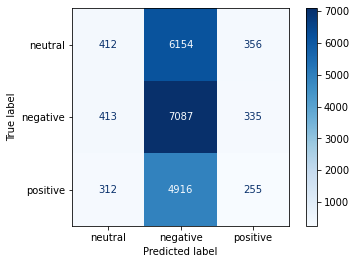

In [ ]:
cm = confusion_matrix(y_train, train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces


val_pred = []


for batch, sample in enumerate(tqdm(dev_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) 
  for i in range(len(faces)) :
    if faces[i] is not None : # face 
      img_pred = np.zeros(3)
      pred = model1(faces[i].to(device))
      prob = F.softmax(pred,1)
      for i in range(prob.shape[0]):
        img_pred += prob[i].detach().cpu().numpy()
      
      val_pred.append(np.argmax(img_pred))
    else:
      val_pred.append(np.random.choice(np.arange(3), p=train_prob))

  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

In [ ]:
y_val = []
for batch, sample in enumerate(tqdm(dev_dataloader)):
  y_val.extend(sample['sentiment'].numpy().tolist())

100%|██████████| 80/80 [01:44<00:00,  1.30s/it]


In [ ]:
print(f'Accuracy score on validation data: {accuracy_score(y_val,val_pred)}')

Accuracy score on validation data: 0.3529527947857002


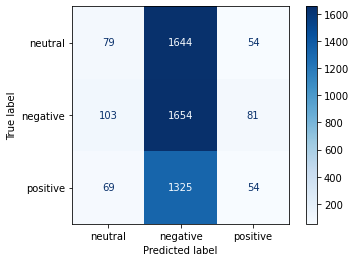

In [ ]:
cm = confusion_matrix(y_val, val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces


test_pred = []


for batch, sample in enumerate(tqdm(test_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) 
  for i in range(len(faces)) :
    if faces[i] is not None : # face 
      img_pred = np.zeros(3)
      pred = model1(faces[i].to(device))
      prob = F.softmax(pred,1)
      for i in range(prob.shape[0]):
        img_pred += prob[i].detach().cpu().numpy()
      
      test_pred.append(np.argmax(img_pred))
    else:
      test_pred.append(np.random.choice(np.arange(3), p=train_prob))

  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

In [ ]:
y_test = []
for batch, sample in enumerate(tqdm(test_dataloader)):
  y_test.extend(sample['sentiment'].numpy().tolist())

100%|██████████| 80/80 [01:44<00:00,  1.31s/it]


In [ ]:
print(f'Accuracy score on test data: {accuracy_score(y_test,test_pred)}')

Accuracy score on test data: 0.4221432800473653


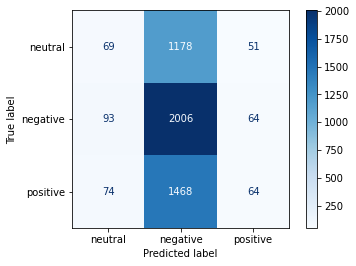

In [ ]:
cm = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)

plt.show()

using mean of all faces' prediction probabilities in an image to predict image's label but adding more weight to class 0 or 2 probabilities:

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces
test_pred = []
y_test = []

for batch, sample in enumerate(tqdm(test_dataloader)):
  y_test.extend(sample['sentiment'].numpy().tolist())
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL)
  for i in range(len(faces)) :
    if faces[i] is not None : # face 
      img_pred = np.zeros(3)
      pred = model1(faces[i].to(device))
      prob = F.softmax(pred,1)
      for i in range(prob.shape[0]):
        if prob[i].argmax(0) == 0 or 2: #add more weight to class 0 & 2 results 
          img_pred += 0.66*prob[i].detach().cpu().numpy()
        else:
          img_pred += prob[i].detach().cpu().numpy()
      
      test_pred.append(np.argmax(img_pred))
    else:
      test_pred.append(np.random.choice(np.arange(3), p=train_prob))

100%|██████████| 80/80 [04:34<00:00,  3.43s/it]


In [ ]:
print(f'Accuracy score on test data: {accuracy_score(y_test,test_pred)}')

Accuracy score on test data: 0.4181961713045194


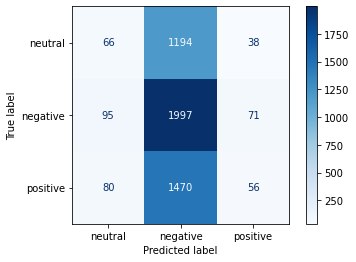

In [ ]:
cm = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)

plt.show()

using weighted counting to predict image's label:

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces
test_pred = []
y_test = []

for batch, sample in enumerate(tqdm(test_dataloader)):
  y_test.extend(sample['sentiment'].numpy().tolist())
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) 
  for i in range(len(faces)) :
    if faces[i] is not None : # face 
      img_pred = np.zeros(3)
      pred = model1(faces[i].to(device))
      prob = F.softmax(pred,1)
      for i in range(prob.shape[0]):
        if prob[i].argmax(0) == 0 or 2: #add more weight to class 0 & 2 counts
          img_pred[prob[i].argmax(0).item()] += 0.66
        else:
          img_pred[prob[i].argmax(0).item()] += 0.33
      
      test_pred.append(np.argmax(img_pred))
    else:
      test_pred.append(np.random.choice(np.arange(3), p=train_prob))

  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

In [ ]:
print(f'Accuracy score on test data: {accuracy_score(y_test,test_pred)}')

Accuracy score on test data: 0.4164199723702388


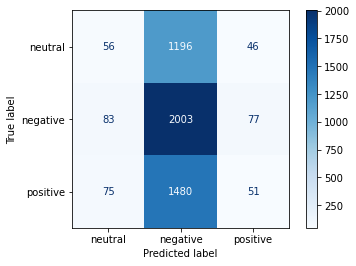

In [ ]:
cm = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)

plt.show()

using unweighted counting to predict image label:

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces
test_pred = []
y_test = []

for batch, sample in enumerate(tqdm(test_dataloader)):
  y_test.extend(sample['sentiment'].numpy().tolist())
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns positions of bbox, eyes, lips ,...
  for i in range(len(faces)) :
    if faces[i] is not None : # face 
      img_pred = np.zeros(3)
      pred = model1(faces[i].to(device))
      prob = F.softmax(pred,1)
      for i in range(prob.shape[0]): #unweighted counting of faces according to their labels
        img_pred[prob[i].argmax(0).item()] += 1
      
      test_pred.append(np.argmax(img_pred))
    else:
      test_pred.append(np.random.choice(np.arange(3), p=train_prob))

  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

In [ ]:
print(f'Accuracy score on test data: {accuracy_score(y_test,test_pred)}')

Accuracy score on test data: 0.4213538582987961


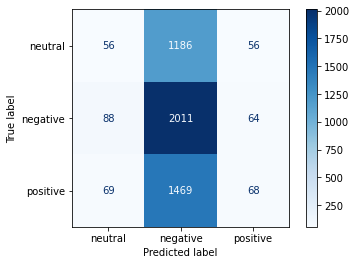

In [ ]:
cm = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)

plt.show()

As the CNN model didn't learn positive or neurtal faces at all, counting faces' labels, weighted counting or weighted probability sum couldn't help improve TP in these classes. So the TPs that we are getting here are mostly from random numbers we generated! Using unweighted probability sum had the best result possible for all three classes.

## زیربخش دوم

## گام ۱


my implementation for augmentations

In [ ]:
class AugFaceDataset(torch.utils.data.Dataset):
    def __init__(self, data_type, data_dir, transforms_list=None):
        super().__init__()
        self.img_labels = pd.read_csv(os.path.join(data_dir, data_type + '.csv'))
        self.data_dir = data_dir
        self.data_type = data_type
        self.transforms_list = transforms_list

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.data_type, str(self.img_labels.iloc[idx, 0])+'.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = self.img_labels.iloc[idx, 1]
        if self.transforms_list:
            brightness_img = (self.transforms_list[0])(img)
            Frequency_img = (self.transforms_list[1])(img)
            spatial_img = (self.transforms_list[2])(img)
            mix_img = (self.transforms_list[3])(img)

        return {'img':torch.tensor(img), 'brightness_img':torch.tensor(brightness_img), 
                'Frequency_img':torch.tensor(Frequency_img), 'spatial_img':torch.tensor(spatial_img),
                'mix_img':torch.tensor(mix_img), 'label':torch.tensor(label)}

In [ ]:
transform_1 = T.Compose([T.ToTensor(), T.ColorJitter(brightness = 0.5,contrast = 0.5)])
transform_2 = T.Compose([T.ToTensor(), T.GaussianBlur(kernel_size=(3,3))])
transform_3 = T.Compose([T.ToTensor(), T.RandomAffine(degrees=(-60,60))])
transform_4 = T.Compose([T.ToTensor(), T.ColorJitter(brightness = 0.5,contrast = 0.5), T.GaussianBlur(kernel_size=(3,3)), T.RandomAffine(degrees=(-120,120))])

transforms_list = [transform_1, transform_2, transform_3, transform_4]

In [ ]:
train_aug_set = AugFaceDataset('train','/content/dataset/face/', transforms_list)
test_aug_set = AugFaceDataset('test','/content/dataset/face/', transforms_list)
dev_aug_set = AugFaceDataset('dev','/content/dataset/face/', transforms_list)

In [ ]:
train_aug_face_loader = DataLoader(train_aug_set, batch_size=64, shuffle=False)
test_aug_face_loader = DataLoader(test_aug_set, batch_size=64, shuffle=False)
dev_aug_face_loader = DataLoader(dev_aug_set, batch_size=64, shuffle=False)

In [ ]:
print("5 results for train dataset augmented faces")
train_first_batch = next(iter(train_aug_face_loader))
mixed_images = train_first_batch['mix_img']
brightness_images = train_first_batch['brightness_img']
Frequency_images = train_first_batch['Frequency_img']
spatial_images = train_first_batch['spatial_img']
randomlist = random.sample(range(0, 64), 5)

5 results for train dataset augmented faces


<ipython-input-55-06078802e50f>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'img':torch.tensor(img), 'brightness_img':torch.tensor(brightness_img),
<ipython-input-55-06078802e50f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'Frequency_img':torch.tensor(Frequency_img), 'spatial_img':torch.tensor(spatial_img),
<ipython-input-55-06078802e50f>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mix_img':torch.tensor(mix_img), 'label':torch.tensor(label)}


In [ ]:
img_arrs=[]
for i in range(5):
  k = randomlist[i]
  img_arrs.append(brightness_images[k,:,:,:].permute(1, 2, 0))
  img_arrs.append(Frequency_images[k,:,:,:].permute(1, 2, 0))
  img_arrs.append(spatial_images[k,:,:,:].permute(1, 2, 0))
  img_arrs.append(mixed_images[k,:,:,:].permute(1, 2, 0))

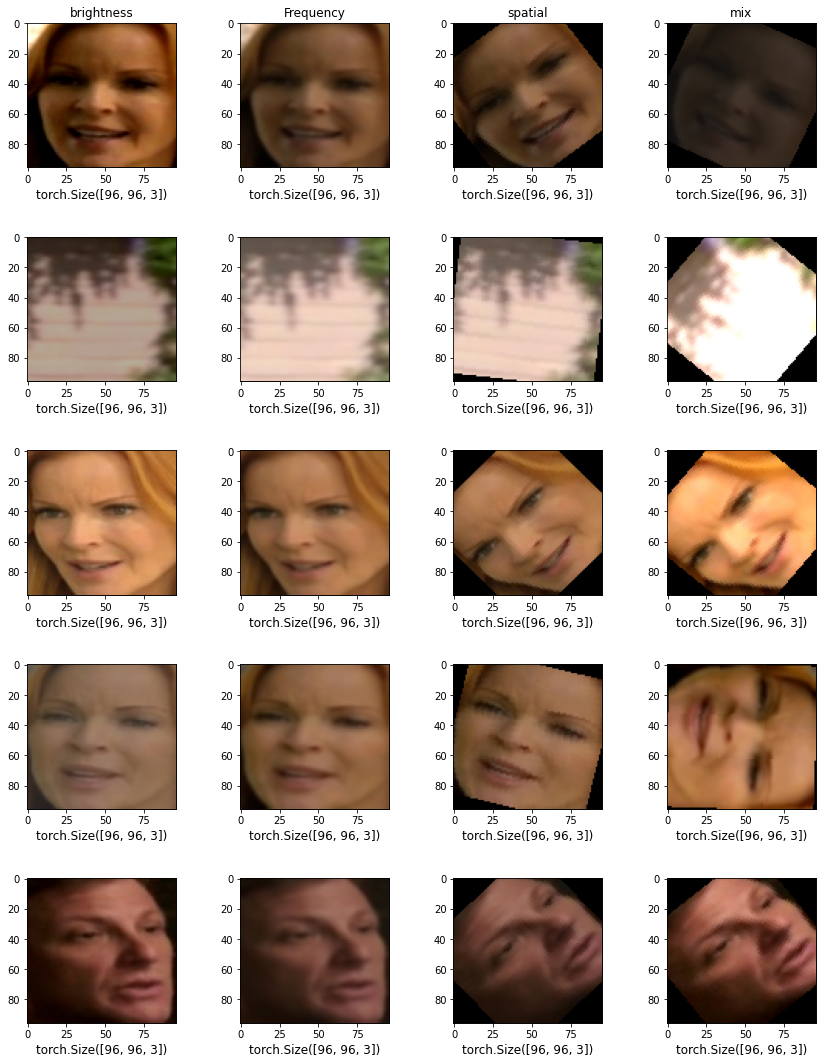

In [ ]:
rows = 5
columns = 4

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))

for num in range(1, rows*columns+1):
    
    fig.add_subplot(rows, columns, num)
    
    idx = num - 1
    
    plt.imshow(img_arrs[idx], aspect='auto')
    plt.xlabel(f'{img_arrs[idx].shape}', fontsize=12)
    
    
fig.tight_layout() # used to adjust padding between subplots 

cols = ['brightness', 'Frequency', 'spatial', 'mix']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])
    



implementation based github link for PRIME augmentations

In [ ]:
!git clone https://github.com/amodas/PRIME-augmentations.git

Cloning into 'PRIME-augmentations'...
remote: Enumerating objects: 605, done.
remote: Counting objects: 100% (605/605), done.
remote: Compressing objects: 100% (363/363), done.
remote: Total 605 (delta 238), reused 576 (delta 220), pack-reused 0
Receiving objects: 100% (605/605), 10.88 MiB | 10.31 MiB/s, done.
Resolving deltas: 100% (238/238), done.


In [ ]:
%cd /content/PRIME-augmentations/

/content/PRIME-augmentations


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from einops import rearrange, repeat
class PRIMEAugModule(torch.nn.Module):
    def __init__(self, augmentations):
        super().__init__()
        self.augmentations = augmentations
        self.num_transforms = len(augmentations)

    def forward(self, x, mask_t):
        aug_x = torch.zeros_like(x)
        for i in range(self.num_transforms):
            aug_x += self.augmentations[i](x) * mask_t[:, i]
        return aug_x

class GeneralizedPRIMEModule(torch.nn.Module):
    def __init__(
        self, preprocess, aug_module, mixture_width=3, 
        mixture_depth=-1, no_jsd=False, max_depth=3
    ):
        """
        Wrapper to perform PRIME augmentation.

        :param preprocess: Preprocessing function which should return a torch tensor
        :param all_ops: Weather to use all augmentation operations (including the forbidden ones such as brightness)
        :param mixture_width: Number of augmentation chains to mix per augmented example
        :param mixture_depth: Depth of augmentation chains. -1 denotes stochastic depth in [1, 3]
        :param no_jsd: Turn off JSD consistency loss
        """
        super().__init__()
        self.preprocess = preprocess
        self.aug_module = aug_module
        self.mixture_width = mixture_width
        self.mixture_depth = mixture_depth
        self.no_jsd = no_jsd

        self.max_depth = max_depth
        self.depth = self.mixture_depth if self.mixture_depth > 0 else self.max_depth
        self.depth_combos = torch.tril(torch.ones((max_depth, max_depth)))

    @torch.no_grad()
    def forward(self, img):

        if self.no_jsd:
            return self.aug(img)
        else:
            return torch.cat((self.preprocess(img), self.aug(img),
                              self.aug(img)), 0)
    


    
    def aug(self, img):
        self.dirichlet = Dirichlet(concentration=torch.tensor([1.] * self.mixture_width, device=img.device))
        self.beta = Beta(concentration1=torch.ones(1, device=img.device, dtype=torch.float32), concentration0=torch.ones(1, device=img.device, dtype=torch.float32))

        ws = self.dirichlet.sample([img.shape[0]])
        m = self.beta.sample([img.shape[0]])[..., None, None]
        print('img.shape',img.shape)
        img_repeat = repeat(img, 'b c h w -> m b c h w', m=self.mixture_width)
        # print(img_repeat.shape)
        img_repeat = rearrange(img_repeat, 'm b c h w -> (m b) c h w')

        # print('img_repeat.shape', img_repeat.shape)

        
        trans_combos = torch.eye(self.aug_module.num_transforms, device=img_repeat.device)
        depth_mask = torch.zeros(img_repeat.shape[0], self.max_depth, 1, 1, 1, device=img_repeat.device)
        trans_mask = torch.zeros(img_repeat.shape[0], self.aug_module.num_transforms, 1, 1, 1, device=img_repeat.device)

        depth_idx = torch.randint(0, len(self.depth_combos), size=(img_repeat.shape[0],))
        depth_mask.data[:, :, 0, 0, 0] = self.depth_combos[depth_idx]

        image_aug = img_repeat.clone()
        # print('image_aug1.shape', image_aug.shape)
        for d in range(self.depth):

            trans_idx = torch.randint(0, len(trans_combos), size=(img_repeat.shape[0],))
            trans_mask.data[:, :, 0, 0, 0] = trans_combos[trans_idx]

            image_aug.data = depth_mask[:, d] * self.aug_module(image_aug, trans_mask) + (1. - depth_mask[:, d]) * image_aug   

        # print('image_aug2.shape', image_aug.shape)
        image_aug = rearrange(image_aug, '(m b) c h w -> m b c h w', m=self.mixture_width)  #self.preprocess(
        # print('image_aug3.shape', image_aug.shape)
        # print('ws', ws, ws.shape)
        mix = torch.einsum('bm, mbchw -> bchw', ws, image_aug)
        mixed = (1. - m) * img + m * mix   #self.preprocess(
        # print('mixed.shape', mixed.shape)
        return mixed

In [ ]:
diffeo_sT = 1.
diffeo_rT = 1.
diffeo_scut = 1.
diffeo_rcut = 1.
diffeo_cutmin = 2
diffeo_cutmax = 100
diffeo_alpha = 1.0

color_jit_cut = 100
color_jit_T = 0.01
color_jit_max_freqs = None

rand_filter_kernel_size = 3
rand_filter_sigma = 4.0

In [ ]:
import utils
from utils.rand_filter import RandomFilter
from utils.color_jitter import RandomSmoothColor
from utils.diffeomorphism import Diffeo

augmentations = []

diffeo = Diffeo(sT=diffeo_sT, rT=diffeo_rT, scut=diffeo_scut, rcut=diffeo_rcut, cutmin=diffeo_cutmin, cutmax=diffeo_cutmax, alpha=diffeo_alpha, stochastic=True)
augmentations.append(diffeo)

color = RandomSmoothColor(cut=color_jit_cut, T=color_jit_T,freq_bandwidth=color_jit_max_freqs, stochastic=True)
augmentations.append(color)

filt = RandomFilter(kernel_size=rand_filter_kernel_size,sigma=rand_filter_sigma, stochastic=True)
augmentations.append(filt)

In [ ]:
from models import AugModel, TransformLayer
# preprocess=TransformLayer(images_resized.mean(axis = 0), images_resized.std(axis = 0))

In [ ]:
prime_module = GeneralizedPRIMEModule(
    preprocess = None,  
    no_jsd=True, max_depth=3, mixture_width=1,
    aug_module=PRIMEAugModule(augmentations),
)

In [ ]:
prime_module.eval()

GeneralizedPRIMEModule(
  (aug_module): PRIMEAugModule()
)

In [ ]:
%pwd

'/content/PRIME-augmentations'

In [ ]:
!mkdir /content/PRIME_aug_faces/

In [ ]:
!mkdir /content/PRIME_aug_faces/train/
!mkdir /content/PRIME_aug_faces/test/
!mkdir /content/PRIME_aug_faces/dev/

In [ ]:
k=0
for  batch , data in enumerate(train_face_loader):
  images = data['img'] * 255
  # images = images.permute(0,3,1,2)
  augment_images = prime_module(images)
  for i in range(len(augment_images)):
    img = augment_images[i,:,:,:] 
    a = cv2.imwrite(f'/content/{k}.jpg',cv2.cvtColor(img.type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))
    k+=1



img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape to

In [ ]:
trainpathes = glob.glob('/content/*.jpg')
dst = '/content/PRIME_aug_faces/train/'
for src_path in trainpathes:
  dst_path = dst + src_path.split('/')[-1]
  shutil.move(src_path, dst_path)

In [ ]:
k=0
for  batch , data in enumerate(test_face_loader):
  images = data['img'] * 255
  # images = images.permute(0,3,1,2)
  augment_images = prime_module(images)
  for i in range(len(augment_images)):
    img = augment_images[i,:,:,:]
    cv2.imwrite(f'/content/{k}.jpg',cv2.cvtColor(img.type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))
    k+=1

testpathes = glob.glob('/content/*.jpg')
dst = '/content/PRIME_aug_faces/test/'
for src_path in testpathes:
  dst_path = dst + src_path.split('/')[-1]
  shutil.move(src_path, dst_path)

img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape to

In [ ]:
k=0
for  batch , data in enumerate(dev_face_loader):
  images = data['img'] * 255 
  # images = images.permute(0,3,1,2)
  augment_images = prime_module(images)
  for i in range(len(augment_images)):
    img = augment_images[i,:,:,:]
    cv2.imwrite(f'/content/{k}.jpg',cv2.cvtColor(img.type(torch.uint8).permute(1, 2, 0).numpy(), cv2.COLOR_RGB2BGR))
    k+=1

devpathes = glob.glob('/content/*.jpg')
dst = '/content/PRIME_aug_faces/dev/'
for src_path in devpathes:
  dst_path = dst + src_path.split('/')[-1]
  shutil.move(src_path, dst_path)

img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape torch.Size([64, 3, 96, 96])
img.shape to

In [ ]:
!zip -r /content/aug_faces.zip /content/aug_faces/*

	zip warning: name not matched: /content/aug_faces/*

zip error: Nothing to do! (try: zip -r /content/aug_faces.zip . -i /content/aug_faces/*)


5 results for train dataset augmented faces with PRIME git


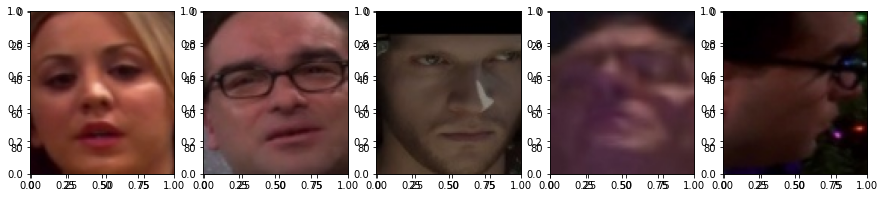

In [ ]:
PRIME_aug_faces_train = glob.glob('/content/PRIME_aug_faces/train/*.jpg')
randomlist = random.sample(range(0, len(PRIME_aug_faces_train)), 5)
img_arrs=[]
for i in range(5):
  k = randomlist[i]
  img_arrs.append(PRIME_aug_faces_train[k] )
print("5 results for train dataset augmented faces with PRIME git")


rows = 1
columns = 5

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*3, rows*3))

for num in range(1, rows*columns+1):
    
    fig.add_subplot(rows, columns, num)
    
    idx = num - 1
    img_array = (cv2.imread(img_arrs[idx])) 
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    # cv2.imshow('image window', image)

    plt.imshow(img_array, aspect='auto')

In [ ]:
%cd /content/

/content


## گام ۲

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = Net().to(device)
print(model)


cuda:0
Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


In [ ]:
def train_loop_1(dataloader, model, loss_fn, optimizer):
  model.train()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss, correct = 0, 0
  for batch, sample_dict in enumerate(dataloader):
    input = sample_dict['mix_img']
    input = input.to('cuda')
    y = sample_dict['label'].to('cuda')
    # Compute prediction and loss
    pred = model(input)
    loss = loss_fn(pred, y)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 100 == 0:
      loss100, current = loss.item(), batch * len(input)
      print(f"loss: {loss100:>7f}  [{current:>5d}/{size:>5d}]")

    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss += loss.item()

  train_loss /= num_batches
  correct /= size
  return train_loss , correct

def validation_loop_1(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for sample_dict in dataloader:
            input = sample_dict['mix_img']
            input = input.to(device)  # move input tensor to GPU
            y = sample_dict['label'].to('cuda')
            pred = model(input)
            loss = loss_fn(pred, sample_dict['label'].to('cuda'))
          
            val_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()


    val_loss /= num_batches
    correct /= size
    print()
    print(f"val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return val_loss, correct



def test_loop_1(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample_dict in dataloader:
            input = sample_dict['mix_img']
            input = input.to(device)  # move input tensor to GPU
            y = sample_dict['label'].to('cuda')
            # print(y)
            pred = model(input)
            # print(pred)
            loss = loss_fn(pred, sample_dict['label'].to('cuda'))
          
            test_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()


    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

In [ ]:
!gdown --id 1--bUNhHUnt2f-msOFrmejistLO6E1E18
model = Net()
model = torch.load('model1.pth', map_location=torch.device(device))
model.eval()


/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1--bUNhHUnt2f-msOFrmejistLO6E1E18
To: /content/model1.pth
100% 4.78M/4.78M [00:00<00:00, 236MB/s]


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
test_loop_1(test_aug_face_loader, model, loss_fn)

<ipython-input-23-06078802e50f>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'img':torch.tensor(img), 'brightness_img':torch.tensor(brightness_img),
<ipython-input-23-06078802e50f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'Frequency_img':torch.tensor(Frequency_img), 'spatial_img':torch.tensor(spatial_img),
<ipython-input-23-06078802e50f>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mix_img':torch.tensor(mix_img), 'label':torch.tensor(label)}


Test Error: 
 Accuracy: 41.5%, Avg loss: 1.091825 



as the model is not basically learning any labels! and it gives all datas label 1, the result is the same

## گام ۳

#### training with augmented dataset

In [ ]:
epochs = 5
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    loss, acc = train_loop_1(train_aug_face_loader, model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)
    loss_v, acc_v = validation_loop_1(dev_aug_face_loader, model, loss_fn)
    val_loss.append(loss_v)
    val_acc.append(acc_v)
    torch.cuda.empty_cache()
print("Done!")

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-23-06078802e50f>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'img':torch.tensor(img), 'brightness_img':torch.tensor(brightness_img),
<ipython-input-23-06078802e50f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'Frequency_img':torch.tensor(Frequency_img), 'spatial_img':torch.tensor(spatial_img),
<ipython-input-23-06078802e50f>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mix_img':torch.tensor(mix_img), 'label':torch.tensor(label)}


Epoch 1
-------------------------------
loss: 1.056510  [    0/28540]
loss: 1.136004  [ 6400/28540]
loss: 1.164978  [12800/28540]
loss: 1.090696  [19200/28540]
loss: 1.055741  [25600/28540]


 20%|██        | 1/5 [03:03<12:14, 183.72s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.098274 

Epoch 2
-------------------------------
loss: 1.056510  [    0/28540]
loss: 1.136004  [ 6400/28540]
loss: 1.164978  [12800/28540]
loss: 1.090696  [19200/28540]
loss: 1.055741  [25600/28540]


 40%|████      | 2/5 [06:06<09:09, 183.19s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.098274 

Epoch 3
-------------------------------
loss: 1.056510  [    0/28540]
loss: 1.136004  [ 6400/28540]
loss: 1.164978  [12800/28540]
loss: 1.090696  [19200/28540]
loss: 1.055741  [25600/28540]


 60%|██████    | 3/5 [09:10<06:06, 183.38s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.098274 

Epoch 4
-------------------------------
loss: 1.056510  [    0/28540]
loss: 1.136004  [ 6400/28540]
loss: 1.164978  [12800/28540]
loss: 1.090696  [19200/28540]
loss: 1.055741  [25600/28540]


 80%|████████  | 4/5 [12:15<03:03, 183.97s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.098274 

Epoch 5
-------------------------------
loss: 1.056510  [    0/28540]
loss: 1.136004  [ 6400/28540]
loss: 1.164978  [12800/28540]
loss: 1.090696  [19200/28540]
loss: 1.055741  [25600/28540]


100%|██████████| 5/5 [15:17<00:00, 183.52s/it]


val Error: 
 Accuracy: 35.2%, Avg loss: 1.098274 

Done!


In [ ]:
test_loop_1(train_aug_face_loader, model, loss_fn)

<ipython-input-23-06078802e50f>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'img':torch.tensor(img), 'brightness_img':torch.tensor(brightness_img),
<ipython-input-23-06078802e50f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'Frequency_img':torch.tensor(Frequency_img), 'spatial_img':torch.tensor(spatial_img),
<ipython-input-23-06078802e50f>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mix_img':torch.tensor(mix_img), 'label':torch.tensor(label)}


Test Error: 
 Accuracy: 37.4%, Avg loss: 1.093395 



training the model on previous+augmented data(more datas) resulted in less accuracy. so learning more didn't happen!

In [ ]:
def visualize_loss_and_acc(loss_values, val_loss_values, acc, val_acc):

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

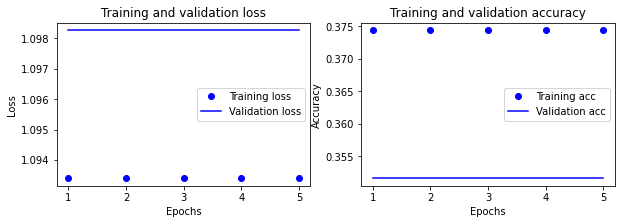

In [ ]:
visualize_loss_and_acc(train_loss, val_loss, train_acc, val_acc)

In [ ]:
# saving
torch.save(model, 'augmented_model.pth')
!cp -r /content/augmented_model.pth /content/drive/MyDrive/deep_learning_project/phase1/

In [6]:
!gdown --id 1-1ZS2sL14UnZ9WpXYKgJW_CjmpHEgIaB
model = Net()
model = torch.load('augmented_model.pth', map_location=torch.device(device))
model.eval()

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-1ZS2sL14UnZ9WpXYKgJW_CjmpHEgIaB
To: /content/augmented_model.pth
100% 4.78M/4.78M [00:00<00:00, 22.4MB/s]


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
train_prob = [0.342,0.387,0.271]

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces


train_pred = []


for batch, sample in enumerate(tqdm(train_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns positions of bbox, eyes, lips ,...
  for i in range(len(faces)) :
    if faces[i] is not None : # face 
      img_pred = np.zeros(3)
      pred = model(faces[i].to(device))
      prob = F.softmax(pred,1)
      for i in range(prob.shape[0]):
        img_pred += prob[i].detach().cpu().numpy()
      
      train_pred.append(np.argmax(img_pred))
    else:
      train_pred.append(np.random.choice(np.arange(3), p=train_prob))

100%|██████████| 20240/20240 [21:49<00:00, 15.45it/s]


In [ ]:
y_train = []
for batch, sample in enumerate(tqdm(train_dataloader)):
  y_train.extend(sample['sentiment'].numpy().tolist())

100%|██████████| 20240/20240 [05:45<00:00, 58.61it/s]


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay, accuracy_score
print(f'Accuracy score on train data: {accuracy_score(y_train,train_pred)}')

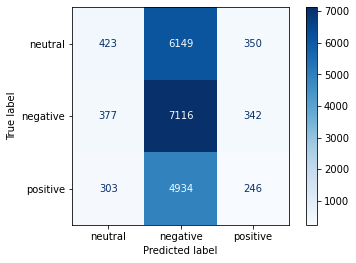

In [ ]:
cm = confusion_matrix(y_train, train_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces


val_pred = []


for batch, sample in enumerate(tqdm(dev_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns positions of bbox, eyes, lips ,...
  for i in range(len(faces)) :
    if faces[i] is not None : # face 
      img_pred = np.zeros(3)
      pred = model(faces[i].to(device))
      prob = F.softmax(pred,1)
      for i in range(prob.shape[0]):
        img_pred += prob[i].detach().cpu().numpy()
      
      val_pred.append(np.argmax(img_pred))
    else:
      val_pred.append(np.random.choice(np.arange(3), p=train_prob))

100%|██████████| 5063/5063 [05:08<00:00, 16.43it/s]


In [ ]:
y_val = []
for batch, sample in enumerate(tqdm(dev_dataloader)):
  y_val.extend(sample['sentiment'].numpy().tolist())

In [ ]:
print(f'Accuracy score on validation data: {accuracy_score(y_val,val_pred)}')

In [ ]:
cm = confusion_matrix(y_val, val_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
transform = T.ToPILImage()
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces


test_pred = []


for batch, sample in enumerate(tqdm(test_dataloader)):
  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns positions of bbox, eyes, lips ,...
  for i in range(len(faces)) :
    if faces[i] is not None : # face 
      img_pred = np.zeros(3)
      pred = model(faces[i].to(device))
      prob = F.softmax(pred,1)
      for i in range(prob.shape[0]):
        img_pred += prob[i].detach().cpu().numpy()
      
      test_pred.append(np.argmax(img_pred))
    else:
      test_pred.append(np.random.choice(np.arange(3), p=train_prob))

100%|██████████| 5067/5067 [05:11<00:00, 16.25it/s]


In [ ]:
y_test = []
for batch, sample in enumerate(tqdm(test_dataloader)):
  y_test.extend(sample['sentiment'].numpy().tolist())

100%|██████████| 5067/5067 [01:18<00:00, 64.15it/s]


In [ ]:
print(f'Accuracy score on test data: {accuracy_score(y_test,test_pred)}')

Accuracy score on test data: 0.41799881586737714


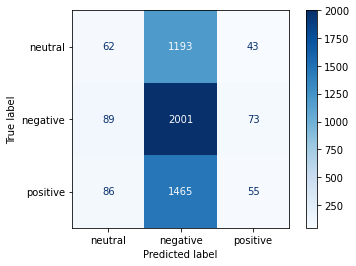

In [ ]:
cm = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)

plt.show()

# بخش دوم

## گام ۲

In [ ]:
def train_loop2(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  resize = transforms.Resize(size=(224, 224))
  for batch, sample_dict in enumerate(dataloader):
       input = resize(sample_dict['image'])
       input = input.to('cuda')
       # Compute prediction and loss
       pred = model(input)
       loss = loss_fn(pred, sample_dict['sentiment'].to('cuda'))
       # Backpropagation
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
       if batch % 100 == 0:
          loss, current = loss.item(), batch * len(input)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def validation_loop2(dataloader, model, loss_fn):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for sample_dict in dataloader:
            input = sample_dict['image']
            input = input.to(device)  # move input tensor to GPU
            output = sample_dict['sentiment'].type(torch.float).to(device)
            pred = model(input)
          
            val_loss += loss_fn(pred, output).item()
            #calculate acc
            pred_class =torch.argmax(pred,dim=1)
            output_class=torch.argmax(output,dim=1)
            correct += (pred_class == output_class).type(torch.float).sum().item()


    val_loss /= num_batches
    correct /= size

    print(f"val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")



def test_loop2(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for sample_dict in dataloader:
            input = sample_dict['image']
            input = input.to(device)  # move input tensor to GPU
            output = sample_dict['sentiment'].to(device)
            pred = model(input)
            test_loss += loss_fn(pred, output).item()
            #calculate acc
            pred_class =torch.argmax(pred,dim=1)
            output_class=torch.argmax(output,dim=1)
            correct += (pred_class == output_class).type(torch.float).sum().item()


    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        # Load the pre-trained mobilenet_v2 model
        self.vgg19 = models.vgg19(pretrained=True)
        
        # Freeze the weights of the mobilenet_v2 model
        for param in self.vgg19.parameters():
            param.requiresGrad = False
        
        # Add a new fully connected layer on top of the mobilenet_v2 model
        self.fc = nn.Linear(1000, 3)

    def flatten(self, x):
        return x.view(x.size(0), -1)
    
    def forward(self, img_array):
        x = self.vgg19(img_array)
        x = self.flatten(x)
        x = self.fc(x)
        output = F.softmax(x, dim=1)
        return output

In [ ]:
# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
model = NeuralNetwork().to(device)
print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

NeuralNetwork(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

## گام ۳

In [ ]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:

epochs = 5

for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop2(train_dataloader, model, loss_fn, optimizer)
    validation_loop2(dev_dataloader, model, loss_fn)
    test_loop2(test_dataloader, model, loss_fn)
    torch.cuda.empty_cache()
print("Done!")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 1.087951  [    0/20240]
loss: 1.082030  [ 6400/20240]
loss: 1.112995  [12800/20240]
loss: 1.065712  [19200/20240]
val Error: 
 Accuracy: 35.8%, Avg loss: 1.121412 



 10%|█         | 1/10 [18:38<2:47:43, 1118.14s/it]

Test Error: 
 Accuracy: 42.4%, Avg loss: 1.082113 

Epoch 2
-------------------------------
loss: 1.062273  [    0/20240]
loss: 1.066573  [ 6400/20240]
loss: 1.133571  [12800/20240]
loss: 1.050153  [19200/20240]
val Error: 
 Accuracy: 36.2%, Avg loss: 1.118273 



 20%|██        | 2/10 [36:56<2:27:30, 1106.28s/it]

Test Error: 
 Accuracy: 42.6%, Avg loss: 1.080575 

Epoch 3
-------------------------------
loss: 1.057786  [    0/20240]
loss: 1.044008  [ 6400/20240]
loss: 1.126217  [12800/20240]
loss: 1.060069  [19200/20240]
val Error: 
 Accuracy: 36.1%, Avg loss: 1.117058 



 30%|███       | 3/10 [55:09<2:08:22, 1100.34s/it]

Test Error: 
 Accuracy: 42.5%, Avg loss: 1.079900 

Epoch 4
-------------------------------
loss: 1.072411  [    0/20240]
loss: 1.058740  [ 6400/20240]
loss: 1.121681  [12800/20240]
loss: 1.064163  [19200/20240]
val Error: 
 Accuracy: 36.3%, Avg loss: 1.117359 



 40%|████      | 4/10 [1:13:15<1:49:27, 1094.58s/it]

Test Error: 
 Accuracy: 42.7%, Avg loss: 1.080325 

Epoch 5
-------------------------------
loss: 1.057129  [    0/20240]
loss: 1.041136  [ 6400/20240]
loss: 1.135608  [12800/20240]
loss: 1.060038  [19200/20240]
val Error: 
 Accuracy: 36.3%, Avg loss: 1.116672 



 50%|█████     | 5/10 [1:31:23<1:31:01, 1092.36s/it]

Test Error: 
 Accuracy: 42.6%, Avg loss: 1.080604 

Epoch 6
-------------------------------
loss: 1.055545  [    0/20240]
loss: 1.066392  [ 6400/20240]
loss: 1.124747  [12800/20240]
loss: 1.063540  [19200/20240]
val Error: 
 Accuracy: 36.1%, Avg loss: 1.115339 



 60%|██████    | 6/10 [1:49:33<1:12:46, 1091.57s/it]

Test Error: 
 Accuracy: 42.7%, Avg loss: 1.079695 

Epoch 7
-------------------------------
loss: 1.060400  [    0/20240]
loss: 1.076510  [ 6400/20240]
loss: 1.143690  [12800/20240]
loss: 1.056988  [19200/20240]
val Error: 
 Accuracy: 36.1%, Avg loss: 1.116542 



 70%|███████   | 7/10 [2:07:44<54:34, 1091.45s/it]  

Test Error: 
 Accuracy: 42.6%, Avg loss: 1.079818 

Epoch 8
-------------------------------
loss: 1.045317  [    0/20240]
loss: 1.053283  [ 6400/20240]
loss: 1.121994  [12800/20240]
loss: 1.052307  [19200/20240]
val Error: 
 Accuracy: 36.3%, Avg loss: 1.116776 



 80%|████████  | 8/10 [2:26:03<36:27, 1093.85s/it]

Test Error: 
 Accuracy: 42.9%, Avg loss: 1.078655 

Epoch 9
-------------------------------
loss: 1.053471  [    0/20240]
loss: 1.074293  [ 6400/20240]
loss: 1.129473  [12800/20240]
loss: 1.059252  [19200/20240]
val Error: 
 Accuracy: 36.4%, Avg loss: 1.115592 



 90%|█████████ | 9/10 [2:44:18<18:14, 1094.13s/it]

Test Error: 
 Accuracy: 42.5%, Avg loss: 1.079962 

Epoch 10
-------------------------------
loss: 1.052021  [    0/20240]


In [ ]:
model.eval()

In [ ]:
resize = transforms.Resize(size=(224, 224))
test_pred = []
y_test = []

with torch.no_grad():
  for sample in tqdm(test_dataloader):
      input = resize(sample['image'])
      input = input.to(device)  # move input tensor to GPU
      y = sample['sentiment_1'].type(torch.float).to(device)
      pred = model(input)
      test_pred.extend(pred.argmax(1).cpu().numpy().tolist())
      y_test.extend(sample['sentiment'].numpy().tolist())
      torch.cuda.empty_cache()

100%|██████████| 80/80 [02:32<00:00,  1.91s/it]


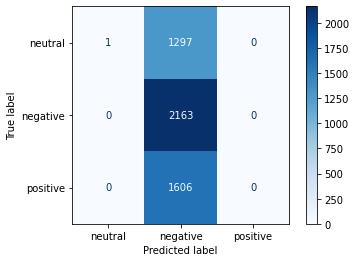

In [ ]:
cm = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)

plt.show()

Compared to part 1, the accuracy is almost the same. part 1 model is partly superior to part 2 model, because TP(True Positive) in neutral and positive classes here is zero which means part 2 model couldn't even predict 1 sample from these classes. It may be caused by the fact that there are usually more than one face in each picture but the sentiment is only related to 1 face so the model couldn't learn it very well

# بخش سوم

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
#!cp /content/drive/MyDrive/deep_learning_project/phase1/model1.pth  /content/
!gdown --id 1--bUNhHUnt2f-msOFrmejistLO6E1E18
model1 = Net()
model1 = torch.load('model1.pth', map_location=torch.device(device))
model1.eval()

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1--bUNhHUnt2f-msOFrmejistLO6E1E18
To: /content/model1.pth
100% 4.78M/4.78M [00:00<00:00, 268MB/s]


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

In [ ]:
#!cp /content/drive/MyDrive/deep_learning_project/phase1/model_ph1_2.pth  /content/
!gdown --id 1jsaZ1RaEqKNd6aoAez99HyX1vcys-wTr
model2 = NeuralNetwork()
model2 = torch.load('model_ph1_2.pth', map_location=torch.device(device))
model2.eval()

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1jsaZ1RaEqKNd6aoAez99HyX1vcys-wTr
To: /content/model_ph1_2.pth
100% 575M/575M [00:01<00:00, 301MB/s]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NeuralNetwork(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [ ]:
def final_model_ph1(img_pred_model1,img_pred_model2,face_count):
  if face_count != 0 :
    # if np.argmax(img_pred_model1) == 0 or 2: # for classes 0 or 2 add weight to model1 who had better results
    #   #pred = (0.9*img_pred_model1+ 0.1*img_pred_model2)/2
    #   pred = img_pred_model1
    # else:
    #   pred = (img_pred_model1+ img_pred_model2)/2 #we got the same accuracy with both models
    pred = (img_pred_model1+ img_pred_model2)/2 
    return np.argmax(pred)
  else:
    return np.argmax(img_pred_model2)

In [ ]:
transform = T.ToPILImage()
resize = transforms.Resize(size=(224, 224))
mtcnn = MTCNN(image_size =96,keep_all=True, post_process=True, device='cuda:0') #keep all faces, load model on cuda, don't normalize faces


test_pred = []
y_test =[]

for batch, sample in enumerate(tqdm(test_dataloader)):
  y_test.extend(sample['sentiment'].numpy().tolist())
  input = resize(sample['image'])
  prob2 = model2(input.to(device))

  imgs_PIL = []
  faces = []
  for i in range(len(sample['image'])):
    imgs_PIL.append(transform(sample['image'][i])) #mtcnn only accepts batches of PIL image

  faces = mtcnn(imgs_PIL) #returns resized faces
  for i in range(len(faces)) :
    img_pred_model1 = np.zeros(3)
    img_pred_model2 = np.zeros(3)
    face_count = int(0)

    img_pred_model2 = prob2[i].detach().cpu().numpy()

    if faces[i] is not None : # faces detected
      pred = model1(faces[i].to(device))
      prob1 = F.softmax(pred,1)
      for j in range(prob1.shape[0]):
        img_pred_model1 += prob1[j].detach().cpu().numpy()
      img_pred_model1 /= len(faces[i])
      face_count = len(faces[i])
    test_pred.append(final_model_ph1(img_pred_model1,img_pred_model2,face_count))
      
    

  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a 

In [ ]:
print(f'Accuracy score on test data: {accuracy_score(y_test,test_pred)}')

Accuracy score on test data: 0.4268798105387803


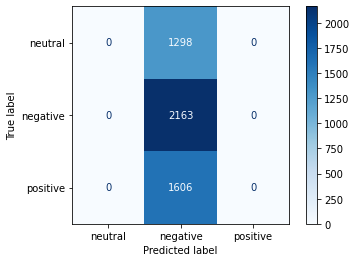

In [ ]:
cm = confusion_matrix(y_test, test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral','negative','positive'])

disp.plot(cmap=plt.cm.Blues)

plt.show()

as both models didn't learn classes 0 and 2 and have the same accuracy and loss, I used mean of their probabilities when faces were detected and model 2 when no face was detected. I also tried other ocmbinations like weighting sum and... but the final result was still the same with no more TPs for classes 0 and 2